# Example: Find a model for Proteins

In [1]:
import json
import gzip
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import TensorDataset, DataLoader


import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Define color-blind-friendly palette
hex1 = ['#648FFF', '#785EF0', '#DC267F', '#FE6100', '#FFB000']
hex1_inverted = hex1[::-1]
colors1=[mcolors.to_rgb(i) for i in hex1]

## Load protein data from PDB dataset

In [2]:
jsons = []
with gzip.open('../../../supplemental_material/pdb/dataset_6000.gz', 'r') as file:
    for line in file:
        jsons.append(json.loads(line))

In [3]:
data = jsons[0]
print(str(len(data)) + " entries")

5139 entries


In [4]:
def char_to_float(s):
    parts = s.split()
    for i in range(len(parts)):
        if parts[i].isalpha():
            parts[i] = float(ord(parts[i]))/100
        else:
            parts[i] = float(parts[i])
    return np.sum(parts)/len(parts)


In [5]:
data[0]['entry']['symmetry']

{'int_tables_number': 4, 'space_group_name_hm': 'P 1 21 1'}

## Generate train and test datasets from entries of the proteins

In [6]:
all_inputs = np.zeros((len(data), 9))
all_targets = np.zeros((len(data), 1))
indices = []
for i in range(len(data)):
    entry = data[i]['entry']
    if 'cell' in entry and 'density_matthews' in entry['exptl_crystal'][0]:
        all_inputs[i, 0] = entry['cell']['angle_alpha']
        all_inputs[i, 1] = entry['cell']['angle_beta']
        all_inputs[i, 2] = entry['cell']['angle_gamma']
        all_inputs[i, 3] = entry['cell']['length_a']
        all_inputs[i, 4] = entry['cell']['length_b']
        all_inputs[i, 5] = entry['cell']['length_c']
        all_inputs[i, 6] = char_to_float(entry['symmetry']['space_group_name_hm'])
        all_inputs[i, 7] = float(entry['symmetry']['int_tables_number'])
        all_inputs[i, 8] = len(entry['pdbx_seq_one_letter_code'])*110    # protein mass estimation
        all_targets[i] = entry['exptl_crystal'][0]['density_matthews']
        indices.append(i)
    # else:
    #     print('skipped %d' % i)
all_inputs = all_inputs[indices]
all_targets = all_targets[indices]

print('Number of entries: %d' % len(all_inputs))

Number of entries: 5075


In [7]:
# Set random seed for reproducibility
np.random.seed(42)

# Shuffle the indices
indices = np.random.permutation(len(all_inputs))

# Split the indices for training, testing, and validation sets
train_indices = indices[:5 * len(all_inputs) // 6]
test_indices = indices[5 * len(all_inputs) // 6:]

# Create the training, testing, and validation sets
inputs_training = all_inputs[train_indices]
targets_training = all_targets[train_indices]
inputs_testing = all_inputs[test_indices]
targets_testing = all_targets[test_indices]

In [8]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
inputs_training = scaler.fit_transform(inputs_training)
inputs_testing = scaler.transform(inputs_testing)

In [9]:
input_tensor = torch.tensor(inputs_training, dtype=torch.float32)
target_tensor = torch.tensor(targets_training, dtype=torch.float32)

## Define Model

In [10]:
# Define the model architecture using a sequential container

# define input size, hidden layer size, output size 
D_i, D_k, D_o = 9, 500, 1

# The model consists of:
model = nn.Sequential(
    nn.Linear(D_i, D_k),
    nn.ReLU(),
    nn.Linear(D_k, D_k),
    nn.ReLU(),
    nn.Linear(D_k, D_k),
    nn.ReLU(),
    nn.Linear(D_k, D_k),
    nn.ReLU(),
    nn.Linear(D_k, D_k),
    nn.ReLU(),
    nn.Linear(D_k, D_k),
    nn.ReLU(),
    nn.Linear(D_k, D_k),
    nn.ReLU(),
    nn.Linear(D_k, D_k),
    nn.ReLU(),
    nn.Linear(D_k, D_k),
    nn.ReLU(),
    nn.Linear(D_k, D_o),
)

In [11]:
# Define the loss function and optimizer
# Mean Squared Error (MSE) is used as the loss function
criterion = nn.MSELoss()

In [12]:
# Adam optimizer is used with weight decay (L2 regularization) to prevent overfitting
optimizer = optim.Adam(model.parameters(), weight_decay=1e-5)
# object that decreases learning rate by half every N epochs 
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)

In [13]:

# Train the model
num_epochs = 1000  # Number of epochs to train the model
losses = []  # List to store the loss value for each epoch
# load data
data_loader = DataLoader(TensorDataset(input_tensor,target_tensor), batch_size=64)
# Iterate over the epochs
for epoch in range(num_epochs):
    epoch_loss = 0.0  # Initialize the loss value for this epoch
    # Iterate over the training data in batches
    for i, dataset in enumerate(data_loader):
        # Get the inputs and targets from the data loader
        inputs, targets = dataset
        # Clear the gradients of all optimized tensors
        optimizer.zero_grad()  
        
        # Forward pass: compute the model output
        outputs = model(inputs)
        # Compute the loss between the model output and the actual targets
        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        loss.backward()        # Compute the gradient of the loss with respect to model parameters
        optimizer.step()       # Update the model parameters based on the computed gradients
        
        # Store the loss value for this epoch
        epoch_loss += loss.item()
    losses.append(epoch_loss)  # Store the loss value for this epoch
    print(f'Epoch {epoch:5d}, loss {epoch_loss:.3f}')
    # tell scheduler to consider updating learning rate 
    scheduler.step()

Epoch     0, loss 139.129
Epoch     1, loss 22.087
Epoch     2, loss 18.227
Epoch     3, loss 17.088
Epoch     4, loss 16.489
Epoch     5, loss 15.901
Epoch     6, loss 15.426
Epoch     7, loss 15.078
Epoch     8, loss 14.685
Epoch     9, loss 14.415
Epoch    10, loss 14.117
Epoch    11, loss 13.856
Epoch    12, loss 13.616
Epoch    13, loss 13.446
Epoch    14, loss 13.236
Epoch    15, loss 13.010
Epoch    16, loss 12.858
Epoch    17, loss 12.643
Epoch    18, loss 12.554
Epoch    19, loss 12.459
Epoch    20, loss 12.200
Epoch    21, loss 12.042
Epoch    22, loss 11.857
Epoch    23, loss 11.725
Epoch    24, loss 11.591
Epoch    25, loss 11.429
Epoch    26, loss 11.256
Epoch    27, loss 11.116
Epoch    28, loss 11.002
Epoch    29, loss 10.850
Epoch    30, loss 10.707
Epoch    31, loss 10.569
Epoch    32, loss 10.453
Epoch    33, loss 10.338
Epoch    34, loss 10.095
Epoch    35, loss 9.932
Epoch    36, loss 9.837
Epoch    37, loss 9.813
Epoch    38, loss 9.589
Epoch    39, loss 9.499
Epoc

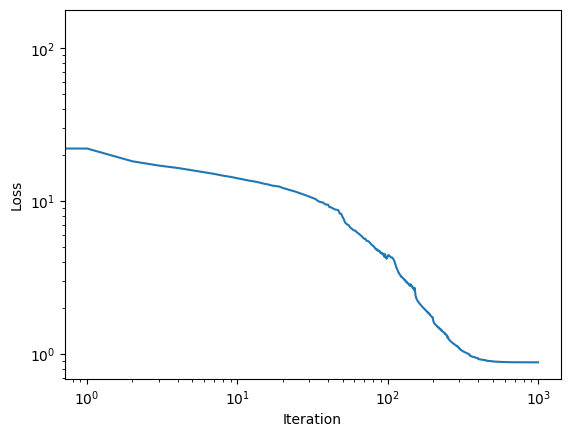

In [14]:
plt.plot(losses)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

In [15]:
predictions_test = model(torch.tensor(inputs_testing, dtype=torch.float32)).detach().numpy()

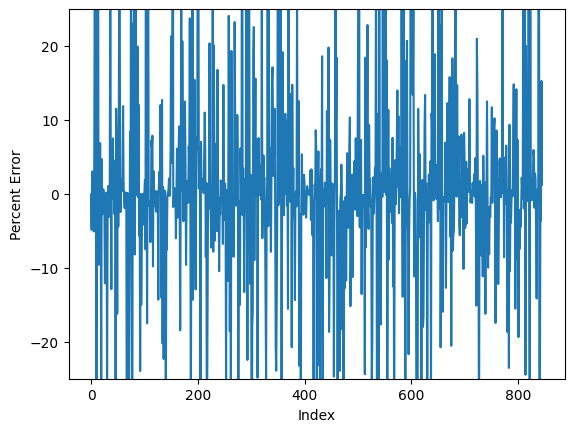

In [16]:
plt.plot(100*(predictions_test/targets_testing-1))
plt.xlabel('Index')
plt.ylabel('Percent Error')
plt.ylim([-25,25])
plt.show()

In [17]:
var_performance = np.sum((predictions_test - targets_testing)**2)/len(predictions_test)
print('Variance of performance: %.3f' % var_performance)

Variance of performance: 0.278


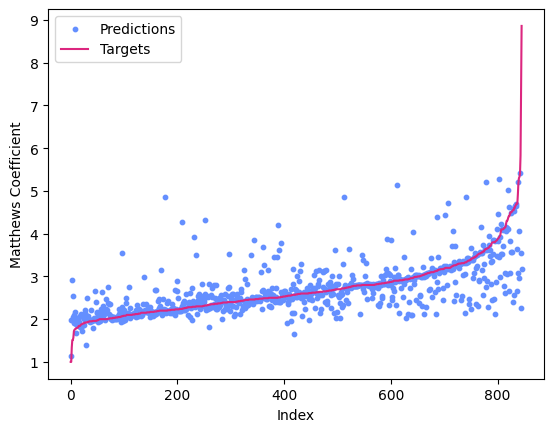

In [18]:
order = np.argsort(targets_testing.flatten())
xvals = np.arange(len(targets_testing))
plt.scatter(xvals,predictions_test[order],label='Predictions',s=10,color=colors1[0])
plt.plot(xvals,targets_testing[order],label='Targets',color=colors1[2])
#plt.fill_between(xvals,targets_testing[order].flatten()-np.sqrt(var_performance),targets_testing[order].flatten()+np.sqrt(var_performance),alpha=0.5,color=colors1[2])
plt.xlabel('Index')
plt.ylabel('Matthews Coefficient')
plt.legend()
plt.show()